In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import tensorflow_probability as tfp
import scipy.special

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
tfd = tfp.distributions
np.random.seed(0)

from LSM_tensorflow import *

2024-03-06 08:59:20.886377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
S0 = 27479.363
sigma = .1797
_lambda = 11.9488

eta1 = 1/0.074
eta2 = 1/0.0608
p = .3316
r = 0.01
d = 0.2

n = 200_000 # sample size
m = 360 # sample length
T = 1 #years

LTV0 = 0.6
LTVH = 0.8
liquidation_penalty = 0.95

degree = 2
seed = 0
# print(n, m, LTV0, LTV0/LTVH)
print(eta1, eta2)

13.513513513513514 16.44736842105263


In [3]:
LTVH = 0.9

start = -0.1
stop  = 0.8
step  = .05
d_arr = np.arange(start, stop+step, step)

start = 0.1
stop  = 0.8
step  = .05
LTV0_arr = np.arange(start, stop+step, step)

start = 10
stop  = m
step  = 10
slice_id_arr = np.arange(start, stop+step, step)

print(LTVH, d_arr, LTV0_arr, slice_id_arr)

0.9 [-0.1  -0.05  0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45
  0.5   0.55  0.6   0.65  0.7   0.75  0.8 ] [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85] [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360]


In [4]:
# Run notebooks in src to get the pickle files
import pickle

# American barrier option prices
with open(r"results1.pickle", "rb") as input_file:
    results1 = pickle.load(input_file)
    
with open(r"results2.pickle", "rb") as input_file:
    results2 = pickle.load(input_file)
        
with open(r"results3.pickle", "rb") as input_file:
    results3 = pickle.load(input_file)
    
with open(r"results_toComplete.pickle", "rb") as input_file:
    results_toComplete = pickle.load(input_file)
    
all_results = results1 + results2 + results3 + results_toComplete
    
# European barrier option prices
with open(r"results_Euro2.pickle", "rb") as input_file:
    results_Euro = pickle.load(input_file)


In [ ]:
# Consolidate data into DataFrame

df = []

e_id = 30
for a in all_results:
    try:
        df.append([a[0], a[1], a[2], a[3].loc[e_id], a[4].loc[e_id]])
    except:
        continue
    
df = pd.DataFrame(df)
df.columns = ['d', 'LTV0', 'slice_id', '_mean', '_var']
df = df.drop_duplicates()
df = df.sort_values(['d', 'LTV0'])

df.LTV0 = df.LTV0.apply(lambda x: round(x, 2))
df.d = df.d.apply(lambda x: round(x, 2))

df = df.loc[~( (df.d == 0.25) & (df.LTV0 <=0.55) )]
df = df.loc[df.LTV0 >= 0.3]
df = df.loc[df.slice_id >= 60]

unique_LTV0 = np.unique(df.LTV0)
unique_d = np.unique(df.d)
LTV0 = unique_LTV0[-1]

unique_slice_id = np.unique(df.slice_id)
slice_id = unique_slice_id[-1]

In [6]:
# Consolidate data into DataFrame
df_Euro = []

for re in results_Euro:
    d = np.ones(m)*re[0]
    LTV0 = np.ones(m)*re[1]
    _mean = re[2].numpy()
    _var = re[3].numpy()
    
    _df = pd.DataFrame([d,LTV0,_mean, _var]).T
    _df = _df.reset_index()
    _df.columns = ['slice_id', 'd', 'LTV0', '_mean', '_var']
    _df.slice_id += 1
    df_Euro.append(_df)
df_Euro = pd.concat(df_Euro).loc[:, ['d', 'LTV0', 'slice_id', '_mean', '_var']]

df_Euro.LTV0 = df_Euro.LTV0.apply(lambda x: round(x, 2))
df_Euro.d = df_Euro.d.apply(lambda x: round(x, 2))
# print(len(df_Euro))
df_Euro = df_Euro.drop_duplicates(['LTV0', 'd', 'slice_id'])
# print(len(df_Euro))

In [27]:
# quantiles for confidence interval
up = scipy.stats.norm().ppf(0.995)
do = scipy.stats.norm().ppf(0.005)

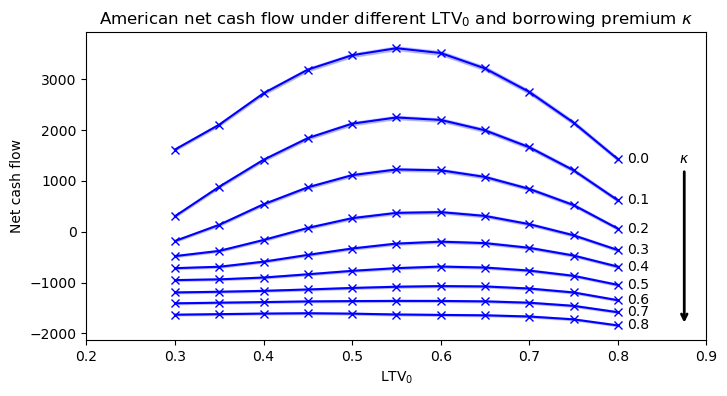

In [29]:
slice_id = 360

plt.figure(figsize=(8,4))

for d in  np.unique(df.d)[2::2]:
    _id = df.slice_id == slice_id
    _id *= df.d == d
    _id *= df.LTV0 >=0.3
    _id *= df.LTV0 <=0.8

    df_slice = df.loc[_id]
    plt.plot(df_slice.LTV0, df_slice._mean - (S0-S0*df_slice.LTV0), marker='x', color='blue')
    
    plt.text(x=0.81, y =  (df_slice._mean - (S0-S0*df_slice.LTV0)).iloc[-1], s = d, va='center')
    
    _up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
    _do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do
        
    plt.fill_between(df_slice.LTV0, _up, _do, color='blue', alpha=0.2)
    
    
x = 0.875
y1 = df.loc[(df.d==.8)&(df.LTV0==0.8)&(df.slice_id==360)]._mean.iloc[0] - (S0-S0*0.8)
y2 = df.loc[(df.d==.0)&(df.LTV0==0.8)&(df.slice_id==360)]._mean.iloc[0] - (S0-S0*0.8)

plt.annotate(xy=(x, y1), xytext=(x, y2), text=r'$\kappa$', va='center', ha='center', 
                             arrowprops=dict(arrowstyle= '->',
                             color='black',
                             lw=2,
                             ls='-'))
plt.title(r'American net cash flow under different LTV$_0$ and borrowing premium $\kappa$')
plt.xlabel(r'LTV$_0$')
plt.ylabel(r'Net cash flow')
plt.xlim((0.2, 0.9))
plt.savefig('AM_net_cash_flow_LTV0s.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
# plt.hlines(0, xmin=0.25, xmax=0.9, zorder=-100, color='black', alpha=0.25)


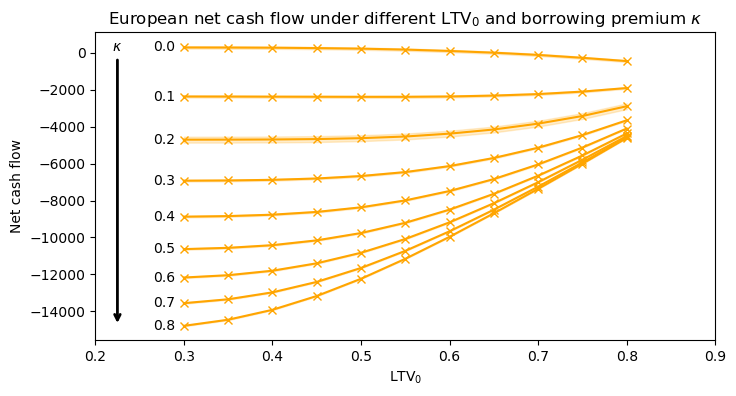

In [30]:
slice_id = 360

plt.figure(figsize=(8,4))

for d in  np.unique(df.d)[2::2]:
    _id = df_Euro.slice_id == slice_id
    _id *= df_Euro.d == d
    _id *= df_Euro.LTV0 >=0.3
    _id *= df_Euro.LTV0 <=0.8

    df_slice = df_Euro.loc[_id]
    plt.plot(df_slice.LTV0, df_slice._mean - (S0-S0*df_slice.LTV0), marker='x', color='orange')
    
    plt.text(x=0.29, y =  (df_slice._mean - (S0-S0*df_slice.LTV0)).iloc[0], s = d, va='center', ha='right')
    
    _up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
    _do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do
        
    plt.fill_between(df_slice.LTV0, _up, _do, color='orange', alpha=0.2)
    
x = 0.225
y1 = df_Euro.loc[(df_Euro.d==.8)&(df_Euro.LTV0==0.3)&(df_Euro.slice_id==360)]._mean.iloc[0] - (S0-S0*0.3)
y2 = df_Euro.loc[(df_Euro.d==.0)&(df_Euro.LTV0==0.3)&(df_Euro.slice_id==360)]._mean.iloc[0] - (S0-S0*0.3)

plt.annotate(xy=(x, y1), xytext=(x, y2), text=r'$\kappa$', va='center', ha='center', 
                             arrowprops=dict(arrowstyle= '->',
                             color='black',
                             lw=2,
                             ls='-'))

plt.title(r'European net cash flow under different LTV$_0$ and borrowing premium $\kappa$')
plt.xlabel(r'LTV$_0$')
plt.ylabel(r'Net cash flow')
plt.xlim((0.2, 0.9))
plt.savefig('EU_net_cash_flow_LTV0s.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
# plt.hlines(0, xmin=0.2, xmax=0.9, zorder=-100, color='black', alpha=0.25)


In [31]:
# Net cash flow surface

from mpl_toolkits.mplot3d import axes3d


X = []
Y = []
Z = []

for d in unique_d[::2]:
    df_slice = df.loc[(df.slice_id == 360) & (df.d==d)]
    df_slice = df_slice.sort_values('LTV0', ascending=False)
    _Z = df_slice._mean - (S0 - S0*df_slice.LTV0)
    if d==0.25:
        continue
    X.append(np.array(df_slice.LTV0))
    Y.append(np.array(df_slice.d))
    Z.append(np.array(_Z))
    
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

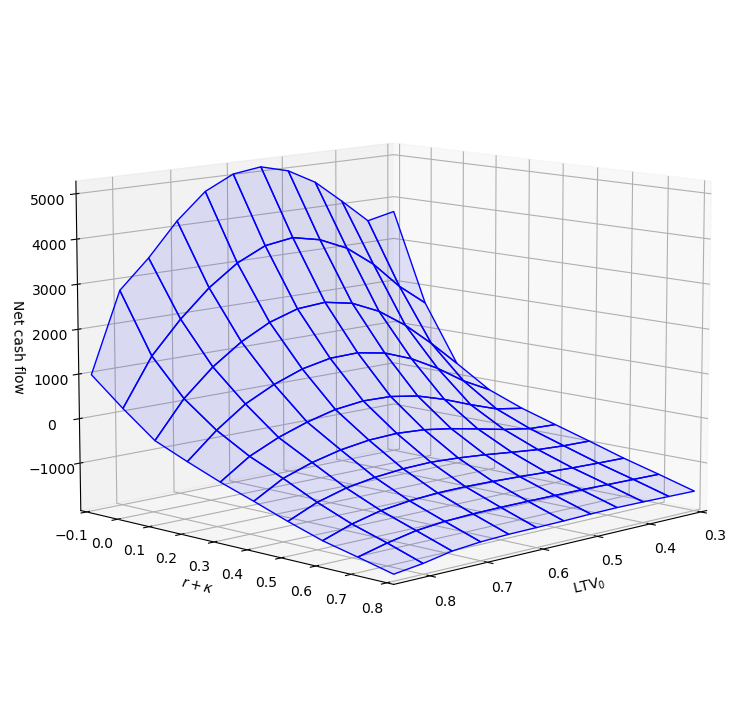

In [32]:

ax = plt.figure(figsize=(12,9)).add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, edgecolor='blue', lw=1, rstride=1, cstride=1, alpha=.1, color='blue')

ax.set_xlabel(r'LTV$_0$')
ax.set_ylabel(r'$r+\kappa$')
ax.set_zlabel(r'Net cash flow')
ax.view_init(10, 45)

ax.set_xlim((np.min(X),np.max(X)))
ax.set_ylim((np.min(Y),np.max(Y)))
ax.set_proj_type("persp")
plt.show()

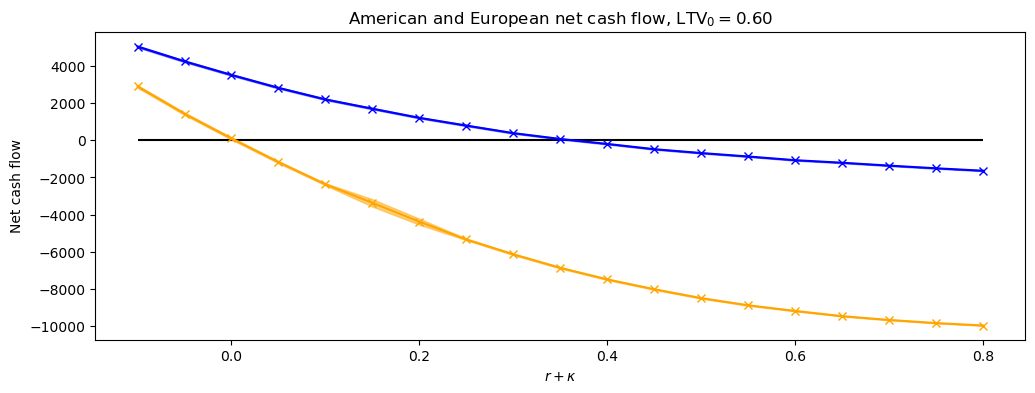

In [33]:
# Net cash flows across borrowing rates
plt.figure(figsize=(12,4))

LTV0 = 0.6

_id = df.LTV0 == LTV0
_id *= df.slice_id == slice_id
df_slice = df.loc[_id].copy()
_up = df_slice._mean - (S0-S0*LTV0) + np.sqrt(df_slice._var/n)*up
_do = df_slice._mean - (S0-S0*LTV0) + np.sqrt(df_slice._var/n)*do
    
plt.plot(df_slice.d, df_slice._mean-(S0-S0*LTV0), marker='x', label=LTV0, color='blue')
plt.fill_between(df_slice.d, _up, _do, color='blue', alpha=0.5)
# plt.text(x=df_slice.d.iloc[0], y=df_slice._mean.iloc[0]-(S0-S0*LTV0), s='%.2f'%LTV0, ha='left')

_id = df_Euro.LTV0 == LTV0
_id *= df_Euro.slice_id == slice_id
_id *= df_Euro.d >= np.min(df.d)

df_slice = df_Euro.loc[_id].copy()
_up = df_slice._mean - (S0-S0*LTV0) + np.sqrt(df_slice._var/n)*up
_do = df_slice._mean - (S0-S0*LTV0) + np.sqrt(df_slice._var/n)*do
    
plt.plot(df_slice.d, df_slice._mean-(S0-S0*LTV0), marker='x', label=LTV0, color='orange')
plt.fill_between(df_slice.d, _up, _do, color='orange', alpha=0.5)

plt.hlines(0, min(df_slice.d), max(df_slice.d), color='black', zorder=-10)

plt.xlabel(r'$r+\kappa$')
plt.ylabel('Net cash flow')
plt.title('American and European net cash flow, LTV$_0=$%.2f'%LTV0)
plt.savefig('LTV0_60.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

plt.show()


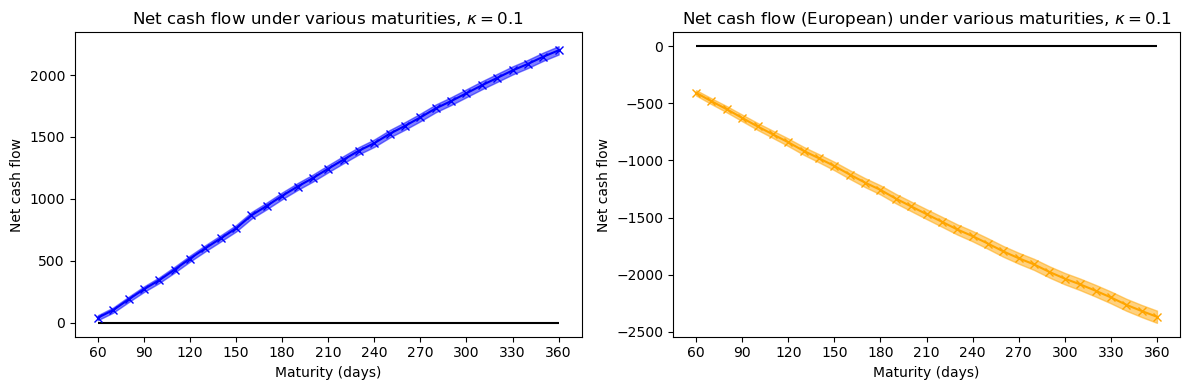

In [34]:
# Comparing American and European net cash flow
LTV0 =  0.6
d = 0.1
_id = df.LTV0 == LTV0
_id *= df.d == d
_id *= df.slice_id >= 7

df_slice = df.loc[_id].copy()
_up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
_do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)
ax[0].set_title(r'Net cash flow under various maturities, $\kappa=0.1$')
ax[0].plot(df_slice.slice_id, df_slice._mean-(S0-S0*df_slice.LTV0), marker='x', label=LTV0, color='blue')
ax[0].fill_between(df_slice.slice_id, _up, _do, color='blue', alpha=0.5)
ax[0].set_ylabel('Net cash flow')
ax[0].set_xlabel('Maturity (days)')
ax[0].hlines(0, 60, 360, zorder=-10, color='black')


_id = df_Euro.LTV0 == LTV0
_id *= df_Euro.d == d
_id *= df_Euro.slice_id >= 7
_id *= df_Euro.slice_id.apply(lambda x: x in  np.array(df_slice.slice_id)) 

df_slice = df_Euro.loc[_id].copy()
_up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
_do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do

ax[1].set_title(r'Net cash flow (European) under various maturities, $\kappa=0.1$')
ax[1].plot(df_slice.slice_id, df_slice._mean-(S0-S0*df_slice.LTV0), marker='x', label=LTV0, color='orange')
ax[1].fill_between(df_slice.slice_id, _up, _do, color='orange', alpha=0.5)
ax[1].set_ylabel('Net cash flow')
ax[1].set_xlabel('Maturity (days)')
ax[1].hlines(0, 60, 360, zorder=-10, color='black')

xticks = np.arange(60, 361, 30)
plt.xticks(xticks,xticks)

plt.tight_layout()
plt.savefig('NCF_maturities_pos_kappa.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

plt.show()

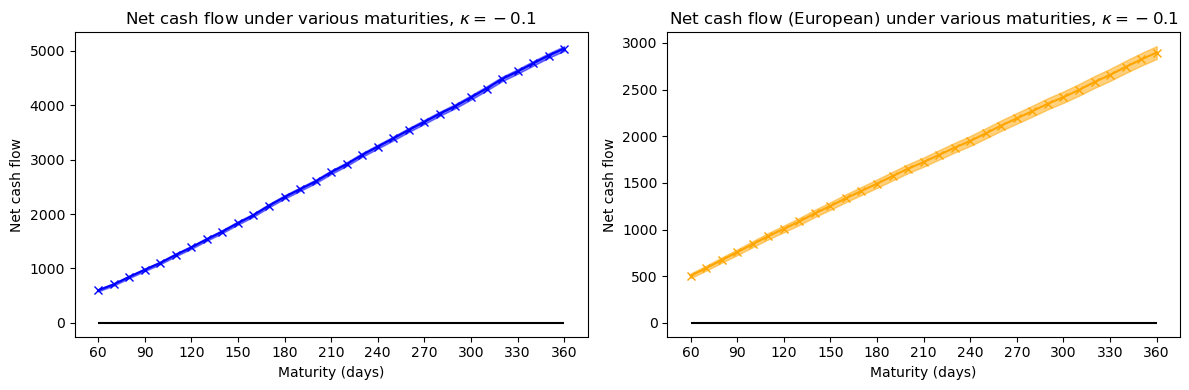

In [35]:
LTV0 =  0.6
d = -0.1
_id = df.LTV0 == LTV0
_id *= df.d == d
_id *= df.slice_id >= 7

df_slice = df.loc[_id].copy()
_up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
_do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)
ax[0].set_title(r'Net cash flow under various maturities, $\kappa=-0.1$')
ax[0].plot(df_slice.slice_id, df_slice._mean-(S0-S0*df_slice.LTV0), marker='x', label=LTV0, color='blue')
ax[0].fill_between(df_slice.slice_id, _up, _do, color='blue', alpha=0.5)
ax[0].set_ylabel('Net cash flow')
ax[0].set_xlabel('Maturity (days)')
ax[0].hlines(0, 60, 360, zorder=-10, color='black')


_id = df_Euro.LTV0 == LTV0
_id *= df_Euro.d == d
_id *= df_Euro.slice_id >= 7
_id *= df_Euro.slice_id.apply(lambda x: x in  np.array(df_slice.slice_id)) 

df_slice = df_Euro.loc[_id].copy()
_up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
_do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do

ax[1].set_title(r'Net cash flow (European) under various maturities, $\kappa=-0.1$')
ax[1].plot(df_slice.slice_id, df_slice._mean-(S0-S0*df_slice.LTV0), marker='x', label=LTV0, color='orange')
ax[1].fill_between(df_slice.slice_id, _up, _do, color='orange', alpha=0.5)
ax[1].set_ylabel('Net cash flow')
ax[1].set_xlabel('Maturity (days)')
ax[1].hlines(0, 60, 360, zorder=-10, color='black')

xticks = np.arange(60, 361, 30)
plt.xticks(xticks,xticks)

plt.tight_layout()

plt.savefig('NCF_maturities_neg_kappa.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [39]:
# Generate fair borrowing rates
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import CubicSpline

In [40]:
kappa_hats = dict()

LTV0 = 0.6

for slice_id in np.unique(df.slice_id):
    _id = df.slice_id == slice_id
    _id *= df.LTV0 == LTV0
    df_slice = df.loc[_id].copy()

    X = np.array(df_slice.d)
    y = df_slice._mean-(S0-S0*LTV0)
    # isotonized cashflow
    y_hat = IsotonicRegression(increasing=False).fit(X, y).predict(X)
    cs = CubicSpline(X, y_hat)
    y_arr = np.linspace(min(X),max(X), 200)
    
    _up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
    _do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do
    
    y_hat = IsotonicRegression(increasing=False).fit(X, _up).predict(X)
    cs_up = CubicSpline(X, y_hat)
    
    y_hat = IsotonicRegression(increasing=False).fit(X, _do).predict(X)
    cs_do = CubicSpline(X, y_hat)
    
    try:
        kappa_hats[slice_id] = [cs.roots()[cs.roots()>0][0],
                                cs_up.roots()[cs_up.roots()>0][0],
                                cs_do.roots()[cs_do.roots()>0][0]]
    except:
        continue
kappa_hats = pd.DataFrame(kappa_hats).T
kappa_hats.columns = ['kappa', 'up', 'do']

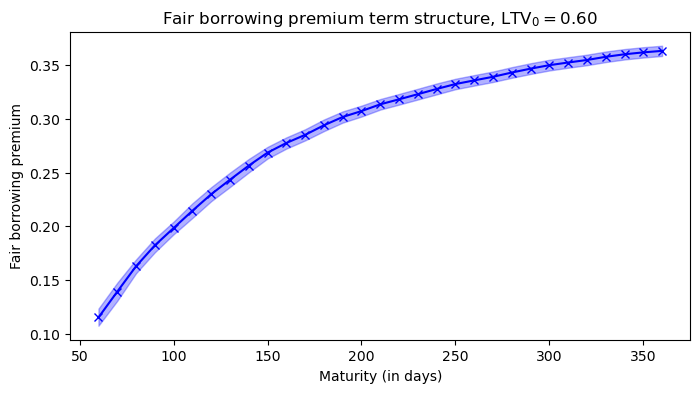

In [41]:
plt.figure(figsize=(8,4))
plt.plot(kappa_hats.kappa, marker='x', color='blue')
plt.fill_between(kappa_hats.index, kappa_hats.up, kappa_hats.do, alpha=0.3, color='blue')
plt.xlabel('Maturity (in days)')
plt.ylabel('Fair borrowing premium')
plt.title('Fair borrowing premium term structure, LTV$_0=$0.60')
plt.show()

In [42]:
EU_kappa_hats = dict()

LTV0 = 0.60

for slice_id in np.unique(df.slice_id):
    _id = df_Euro.slice_id == slice_id
    _id *= df_Euro.LTV0 == LTV0
    df_slice = df_Euro.loc[_id].copy()

    X = np.array(df_slice.d)
    y = df_slice._mean-(S0-S0*LTV0)
    # isotonized cashflow
    y_hat = IsotonicRegression(increasing=False).fit(X, y).predict(X)
    cs = CubicSpline(X, y_hat)
    y_arr = np.linspace(min(X),max(X), 200)
    
    _up = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*up
    _do = df_slice._mean - (S0-S0*df_slice.LTV0) + np.sqrt(df_slice._var/n)*do
    
    y_hat = IsotonicRegression(increasing=False).fit(X, _up).predict(X)
    cs_up = CubicSpline(X, y_hat)
    
    y_hat = IsotonicRegression(increasing=False).fit(X, _do).predict(X)
    cs_do = CubicSpline(X, y_hat)
    
    try:
        EU_kappa_hats[slice_id] = [cs.roots()[cs.roots()>0][0],
                                cs_up.roots()[cs_up.roots()>0][0],
                                cs_do.roots()[cs_do.roots()>0][0]]
    except:
        continue
EU_kappa_hats = pd.DataFrame(EU_kappa_hats).T
EU_kappa_hats.columns = ['kappa', 'up', 'do']

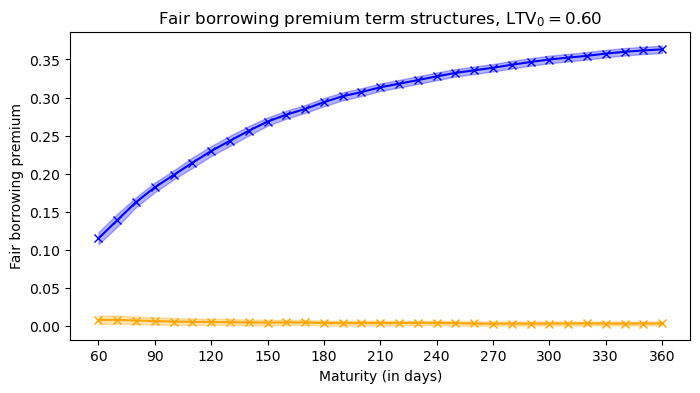

In [43]:
plt.figure(figsize=(8,4))

plt.plot(kappa_hats.kappa, marker='x', color='blue')
plt.fill_between(kappa_hats.index, kappa_hats.up, kappa_hats.do, alpha=0.3, color='blue')
plt.plot(EU_kappa_hats.kappa, marker='x', color='orange')
plt.fill_between(EU_kappa_hats.index, EU_kappa_hats.up, EU_kappa_hats.do, alpha=0.3, color='orange')
plt.xlabel('Maturity (in days)')
plt.ylabel('Fair borrowing premium')
plt.title('Fair borrowing premium term structures, LTV$_0=$0.60')

xticks = np.arange(60, 361, 30)
plt.xticks(xticks,xticks)

plt.savefig('Term_structure.pdf',
            transparent=True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [44]:
# Fair borrowing rate term structure surface
all_kappa_hats = []
for LTV0 in unique_LTV0:
    kappa_hats = dict()
    for slice_id in np.unique(df.slice_id):
        _id = df.slice_id == slice_id
        _id *= df.LTV0 == LTV0
        df_slice = df.loc[_id].copy()

        X = np.array(df_slice.d)
        y = df_slice._mean-(S0-S0*LTV0)
        # isotonized cashflow
        y_hat = IsotonicRegression(increasing=False).fit(X, y).predict(X)
        cs = CubicSpline(X, y_hat)
        y_arr = np.linspace(min(X),max(X), 200)
        
        kappa_hats[slice_id] = [slice_id,
                                LTV0,
                                cs.roots()[cs.roots()>0][0]]
        
    kappa_hats = pd.DataFrame(kappa_hats).T
    kappa_hats.columns = ['slice_id', 'LTV0', 'kappa']
    all_kappa_hats.append(kappa_hats)

In [45]:
all_kappa_hats = pd.concat(all_kappa_hats)

In [46]:
_id = all_kappa_hats.LTV0 >= 0.5
all_kappa_hats = all_kappa_hats.loc[_id]

In [47]:
Xs = []
Ys = []
Zs = []

for slice_id in np.unique(df.slice_id):
    _id = all_kappa_hats.slice_id == slice_id
    df_slice = all_kappa_hats.loc[_id].copy()
    
    X = np.array(df_slice.slice_id)
    Y = np.array(df_slice.LTV0)
    Z = np.array(df_slice.kappa)
    
    Xs.append(X)
    Ys.append(Y)
    Zs.append(Z)
    
Xs = np.array(Xs)
Ys = np.array(Ys)
Zs = np.array(Zs)

/var/folders/kk/sd470zbn2vb_bnfmc96vbwjm0000gn/T/ipykernel_54343/497480202.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


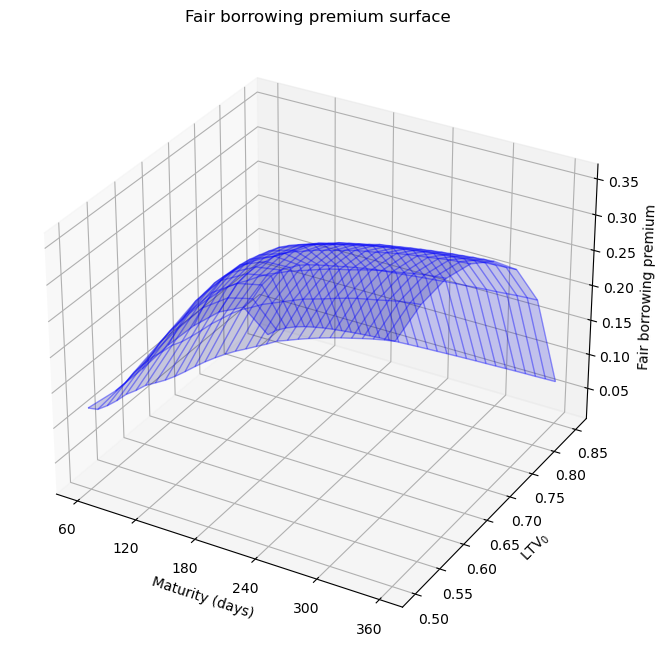

In [48]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))

ax.plot_surface(Xs, Ys, Zs, alpha=.2, color='blue')
ax.plot_wireframe(Xs, Ys, Zs, alpha=.4, linewidth=1, rstride=1, cstride=1, color='blue')

xticks = np.arange(60, 361, 60)
ax.set_xticks(xticks, xticks)

ax.set_xlabel(r'Maturity (days)')
ax.set_ylabel(r'LTV$_0$')
ax.set_zlabel(r'Fair borrowing premium')

plt.title('Fair borrowing premium surface')
plt.tight_layout()
plt.savefig('FBR_surface.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)
